<a href="https://colab.research.google.com/github/VishwasMore/Food-Vision-Project/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Project 

## Check GPU 

Not all the GPU's are compatible with mixed precision training 

Colab Offers 
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)


Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-653c6376-2bcd-bd5f-ba42-0af1c846a3fe)


In [22]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 41kB/s 
     |████████████████████████████████| 471kB 53.9MB/s 
     |████████████████████████████████| 3.8MB 20.7MB/s 
     |████████████████████████████████| 2.9MB 47.3MB/s 
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


## Get Helper Functions

In [3]:
!wget https://raw.githubusercontent.com/VishwasMore/Food-Vision-Project/main/helper_functions.py

--2021-06-01 17:55:34--  https://raw.githubusercontent.com/VishwasMore/Food-Vision-Project/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2021-06-01 17:55:34 (105 MB/s) - ‘helper_functions.py.2’ saved [10245/10245]



In [4]:
# Import helper fuctions 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Get Data from Tensorflow Datasets 

https://www.tensorflow.org/datasets/catalog/overview

In [5]:
# Get the data we need 
import tensorflow_datasets as tfds

In [6]:
# List all available datasets and check if our dataset is available
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [7]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets shuffled in tuple format (data, label)
                                             with_info=True)

## Exploring the Food101 Data from Tensorflow Datasets

We need to find 
* Classnames 
* The shape of our input data (image tensors)
* The datatype of our input data 
* What the labels look like (e.g. are they one-hot-encoded or are they label encoded)
* Do the labels match up with the class names?

In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data 
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
# Output info about our training sample 
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image Datatype: {image.dtype},
  Target class from Food 101 (tensor form): {label},
  Class name (string form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Target class from Food 101 (tensor form): 93,
  Class name (string form): steak
  


In [12]:
# What does our image tensor from TFDS's Food 101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[113,  50,  41],
        [111,  48,  39],
        [109,  46,  37],
        ...,
        [243, 226, 219],
        [242, 223, 217],
        [241, 222, 216]],

       [[117,  54,  45],
        [114,  51,  42],
        [111,  48,  39],
        ...,
        [230, 210, 201],
        [226, 203, 197],
        [221, 198, 190]],

       [[118,  58,  50],
        [116,  56,  48],
        [113,  53,  45],
        ...,
        [179, 149, 138],
        [169, 136, 127],
        [159, 127, 116]],

       ...,

       [[232, 241, 248],
        [232, 241, 248],
        [232, 241, 248],
        ...,
        [194, 183, 179],
        [194, 183, 179],
        [194, 183, 179]],

       [[231, 240, 247],
        [231, 240, 247],
        [232, 241, 248],
        ...,
        [194, 183, 179],
        [194, 183, 179],
        [194, 183, 179]],

       [[231, 240, 247],
        [231, 240, 247],
        [231, 240, 247],
        ...,
        [194, 183, 17

In [13]:
# What are the min and max value of out tensors?

import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an Image from TensorFlow Datasets

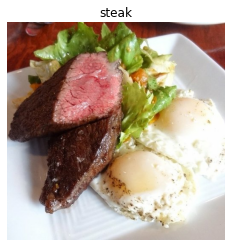

In [14]:
# Plot an Image Tensor 
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with right image 
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data?
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixels values are between 0 & 255)

What we know models like? 
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:

1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from unit8 to float32


In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[113  50  41]
  [111  48  39]
  [109  46  37]
  ...
  [243 226 219]
  [242 223 217]
  [241 222 216]]

 [[117  54  45]
  [114  51  42]
  [111  48  39]
  ...
  [230 210 201]
  [226 203 197]
  [221 198 190]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[113.87245   50.87245   41.87245 ]
  [109.091835  46.091835  37.091835]
  [112.06633   49.06633   40.06633 ]
  ...
  [243.97449  228.12238  224.41829 ]
  [238.95403  219.69382  213.59685 ]
  [230.43864  208.86722  202.40799 ]]

 [[117.31122   57.908165  49.908165]
  [112.93368   52.933674  44.933674]
  [108.37245   48.37245   40.37245 ]
  ...
  [155.57123  118.78546  107.759964]
  [141.12746  102.70395   88.056   ]
  [121.188446  79.85681   66.16293 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and Prepare datasets

 https://www.tensorflow.org/guide/data_performance

In [17]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create Modelling Callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [19]:
# Create tensorboard callback (from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create model checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup Mixed Precision

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision
Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [20]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Build Feature Extraction Model

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs) 

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


16711680/16705208 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Check layer dtype policy 

In [24]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if False, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [26]:
#  Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit feature extraction model

In [28]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210601-180902
Epoch 1/3
2368/2368 [==============================] - 233s 83ms/step - loss: 2.3253 - accuracy: 0.4644 - val_loss: 1.2233 - val_accuracy: 0.6814


Epoch 2/3
2368/2368 [==============================] - 168s 70ms/step - loss: 1.3080 - accuracy: 0.6640 - val_loss: 1.1272 - val_accuracy: 0.7002


Epoch 3/3
2368/2368 [==============================] - 165s 69ms/step - loss: 1.1428 - accuracy: 0.7042 - val_loss: 1.0859 - val_accuracy: 0.7058


In [29]:
# Evaluate model on whole dataset

results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 56s 71ms/step - loss: 1.0911 - accuracy: 0.7066


[1.091111660003662, 0.7066138386726379]

## Save the Model

In [32]:
## Saving model to Google Drive (optional)

# Create save path to drive 
save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [33]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [34]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [35]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [36]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 48s 59ms/step - loss: 1.0911 - accuracy: 0.7066


[1.091111660003662, 0.7066138386726379]

In [37]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

## Preparing Models layer for Fine Tuning

In [38]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("/content/07_efficientnetb0_feature_extract_model_mixed_precision")

In [39]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [40]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [41]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float


Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy "mixed_policy16" is using it

**Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting

### Creating Early Stopping Callback
The `EarlyStopping` callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

In [42]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

### Learning Rate Callback

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

In [43]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [44]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [45]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20210601-183734
Epoch 1/100
2368/2368 [==============================] - 301s 122ms/step - loss: 0.9933 - accuracy: 0.7343 - val_loss: 0.8410 - val_accuracy: 0.7662
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 294s 121ms/step - loss: 0.5948 - accuracy: 0.8379 - val_loss: 0.7979 - val_accuracy: 0.7839
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 292s 123ms/step - loss: 0.3326 - accuracy: 0.9073 - val_loss: 0.8410 - val_accuracy: 0.7834
Epoch 4/100
2368/2368 [==============================] - 290s 122ms/step - loss: 0.1679 - accuracy: 0.9504 - val_loss: 0.9672 - val_accuracy: 0.7760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 289s 121ms/step - loss: 0.0490 - accuracy: 0.9882 - val_loss: 1.0426 - val_accuracy: 0.7963


In [46]:
# Save model to Google Drive 
loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets
